Применим знания на практике: с помощью pandahouse попробуем выгрузить нужные данные из ClickHouse и проанализируем их в python. 

На этот раз новый датасет, содержащий информацию об объявлениях на Airbnb в Лондоне 🇬🇧.

* ldn_listings – информация о жилье, включая полные описания, характеристики и средние оценки в отзывах; поскольку столбцов очень много, нужные перечислены в текстах самих задач

**1. Для начала, проверим правильность подключения к ClickHouse через pandahouse, отправив простой запрос: выведите количество строк в таблице ldn_listings.**

In [1]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
connection = dict(database='default',
                  host='https://clickhouse.lab.karpov.courses',
                  user='student',
                  password='dpo_python_2020')

In [3]:
query = """
SELECT count(*) as rows
FROM ldn_listings
"""
df = ph.read_clickhouse(query, connection=connection)
df.head()

,rows
0,85207


**2. Выгрузите из таблицы данные о цене в зависимости от типа жилья. Необходимые столбцы:**

* price – цена за ночь
* room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)

**Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию id.**

In [4]:
query = """
SELECT 
    id, room_type, toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
FROM  
    ldn_listings
ORDER BY id
LIMIT 1000
"""
df = ph.read_clickhouse(query, connection=connection)
df.head()

,id,room_type,price
0,13913,Private room,65.0
1,15400,Entire home/apt,100.0
2,17402,Entire home/apt,300.0
3,17506,Private room,150.0
4,25023,Entire home/apt,65.0


In [5]:
df.groupby('room_type').price.quantile(q=0.75)

room_type
Entire home/apt    160.00
Hotel room         157.00
Private room        70.00
Shared room         69.25
Name: price, dtype: float64

Ответ: Private room 70.00

**3. К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating). В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32.**

Hint: toFloat32OrNull(столбец)

Д**авайте построим график рассеивания, который покажет зависимость средней оценки от средней цены по типу жилья.**

**Исходная таблица должна выглядеть так:**


| room_type       | price      |review_scores_rating|
|-----------------|------------|--------------------|
| Private room    |         65 | 96.0               |
| Entire home/apt |        100 | 78.0               |

1) сгруппируйте датафрейм по типу жилья и посчитайте среднее для цены и рейтинга (не забудьте привести рейтинг к типу float)

2) используйте sns.scatterplot, чтобы построить график рассеивания средней цены (ось X) и рейтинга (ось Y) c разбивкой по типу жилья (параметр hue)

**Среди представленных ниже графиков выберите корректный:**

![](https://storage.yandexcloud.net/klms-public/production/learning-content/11/77/598/1724/7851/image.png)



In [6]:
query = """
SELECT 
    room_type, toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price, toFloat32OrNull(replaceRegexpAll(review_scores_rating, '[$,]', '')) as review_scores_rating
FROM  
    ldn_listings
WHERE review_scores_rating is not NULL
LIMIT 1000
"""
df = ph.read_clickhouse(query, connection=connection)
df.head()

,room_type,price,review_scores_rating
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0


In [7]:
df.groupby('room_type').price.mean()

room_type
Entire home/apt    135.882950
Hotel room         134.000000
Private room        54.642437
Shared room         21.000000
Name: price, dtype: float32

In [8]:
df.groupby('room_type').review_scores_rating.mean()

room_type
Entire home/apt    93.568787
Hotel room         92.500000
Private room       94.766205
Shared room        90.000000
Name: review_scores_rating, dtype: float32

In [9]:
mean_df = df.groupby('room_type', as_index = False).agg({'price': 'mean', 'review_scores_rating' : 'mean'})
mean_df

,room_type,price,review_scores_rating
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


<Axes: xlabel='price', ylabel='review_scores_rating'>

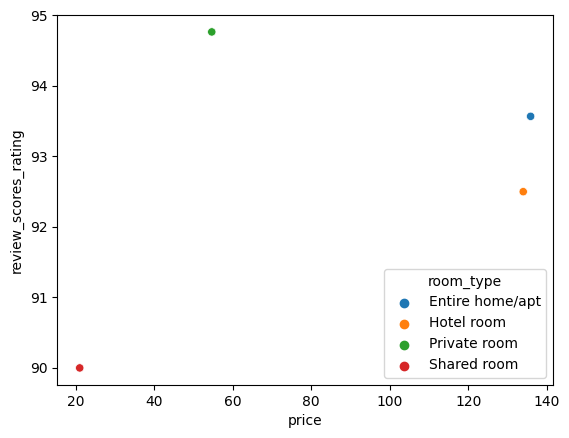

In [10]:
sns.scatterplot(data = mean_df, x = 'price', y = 'review_scores_rating', hue = 'room_type')

* 3
* **2**
* 1
* 4

**4. Итак, помимо аренды жилья, на Airbnb также есть "Впечатления" — мероприятия, которые организуют местные жители.**

**Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != 'none'). Для каждого уникального пользователя выгрузите только две колонки:**

* host_id – идентификатор хозяина (уникальный)
* host_verifications – какими способами хост подтвердил свой профиль

Затем обработайте столбец host_verifications:

1. В ячейках находятся строковые представления списка (например, как результат str([1, 2, 3])). Приведите их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта:

"['email', 'phone', 'facebook']" -> ['email', 'phone', 'facebook']

2. Используйте методы explode и value_counts, чтобы посчитать, сколько раз встречается каждый способ верификации

Сколько хозяев подтвердили профиль с помощью аккаунта Google?

In [11]:
query = """
SELECT DISTINCT host_id, host_verifications
FROM ldn_listings
WHERE experiences_offered != 'none'
"""
df = ph.read_clickhouse(query, connection=connection)
df.head()

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."


In [12]:
df.host_verifications = df.host_verifications.apply(lambda x : x.strip('[').strip(']').replace("'", '').split(', '))
df = df.explode('host_verifications')
df.head()

,host_id,host_verifications
0,54730,email
0,54730,phone
0,54730,facebook
0,54730,reviews
0,54730,offline_government_id


In [13]:
df.host_verifications.value_counts()

host_verifications
phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: count, dtype: int64

Ответ: 34

**5. Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. Новый столбец назовите experiences_count.**

**Пример трёх строк результирующей таблицы: в районе City of London для 7 объявлений указан тип впечатления business, для одного – family.**


| neighbourhood_cleansed | experiences_offered | experiences_count |
|------------------------|---------------------|-------------------|
| City of London         | business            |                 7 |
| City of London         | family              |                 1 |
| City of London         | romantic            |                 1 |


**Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк. Затем преобразуйте данные с помощью pivot, поместив в индексы название района, столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. Визуализируйте результат с помощью sns.heatmap() c палитрой cmap=sns.cubehelix_palette(as_cmap=True).**

**Какой график получился?**

![](https://storage.yandexcloud.net/klms-public/production/learning-content/11/77/598/1724/7853/image2.png)

In [14]:
query = """
SELECT neighbourhood_cleansed, experiences_offered, count(*) as experiences_count
FROM ldn_listings
WHERE experiences_offered != 'none'
GROUP BY neighbourhood_cleansed, experiences_offered
ORDER BY experiences_count DESC
LIMIT 100
"""
df = ph.read_clickhouse(query, connection=connection)
df.head()

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48


In [15]:
df = df.pivot(index = 'neighbourhood_cleansed', columns = 'experiences_offered', values = 'experiences_count')
df.head()

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,NaN,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,NaN,NaN,NaN
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,NaN,4.0


<Axes: xlabel='experiences_offered', ylabel='neighbourhood_cleansed'>

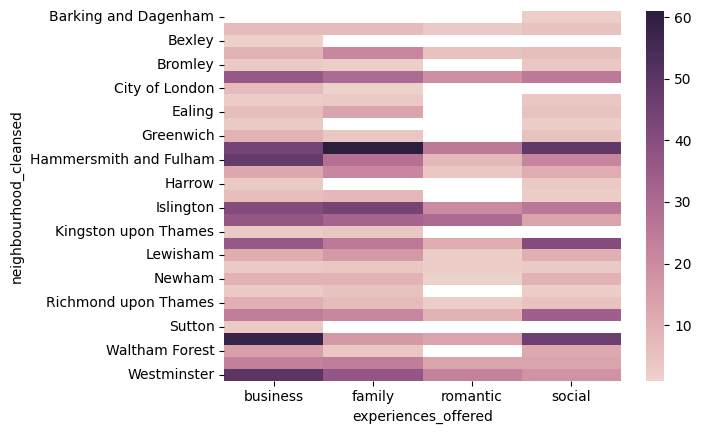

In [16]:
sns.heatmap(data = df,cmap=sns.cubehelix_palette(as_cmap=True))

* **1**
* 3
* 4
* 2

**6. Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. Необходимые для составления запроса столбцы:**

* room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
* price – цена за ночь 
* experiences_offered – вид доступного впечатления (оставить не 'none')

**Пример части результирующей таблицы:**


| room_type       | price_corr |
|-----------------|------------|
| Private room    |         65 |
| Entire home/apt |        100 |
| Entire home/apt |        ... |

Hint: replaceRegexpAll(столбец, что_заменить, на_что_заменить) – паттерн [$,] чтобы избавиться от $ и запятых; toFloat32OrNull(столбец)

**Далее постройте два графика, используя distplot из библиотеки seaborn:**

* На первом отобразите исходные распределения цен для каждого типа жилья
* На втором – логарифмированные значения (np.log())

Среди представленных графиков выберите два соответствующих.
![](https://storage.yandexcloud.net/klms-public/production/learning-content/11/77/598/1724/7854/image.png)

In [17]:
query = """
SELECT room_type, toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price_corr
FROM ldn_listings
WHERE experiences_offered != 'none'
"""
df = ph.read_clickhouse(query, connection=connection)
df.head()

,room_type,price_corr
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0


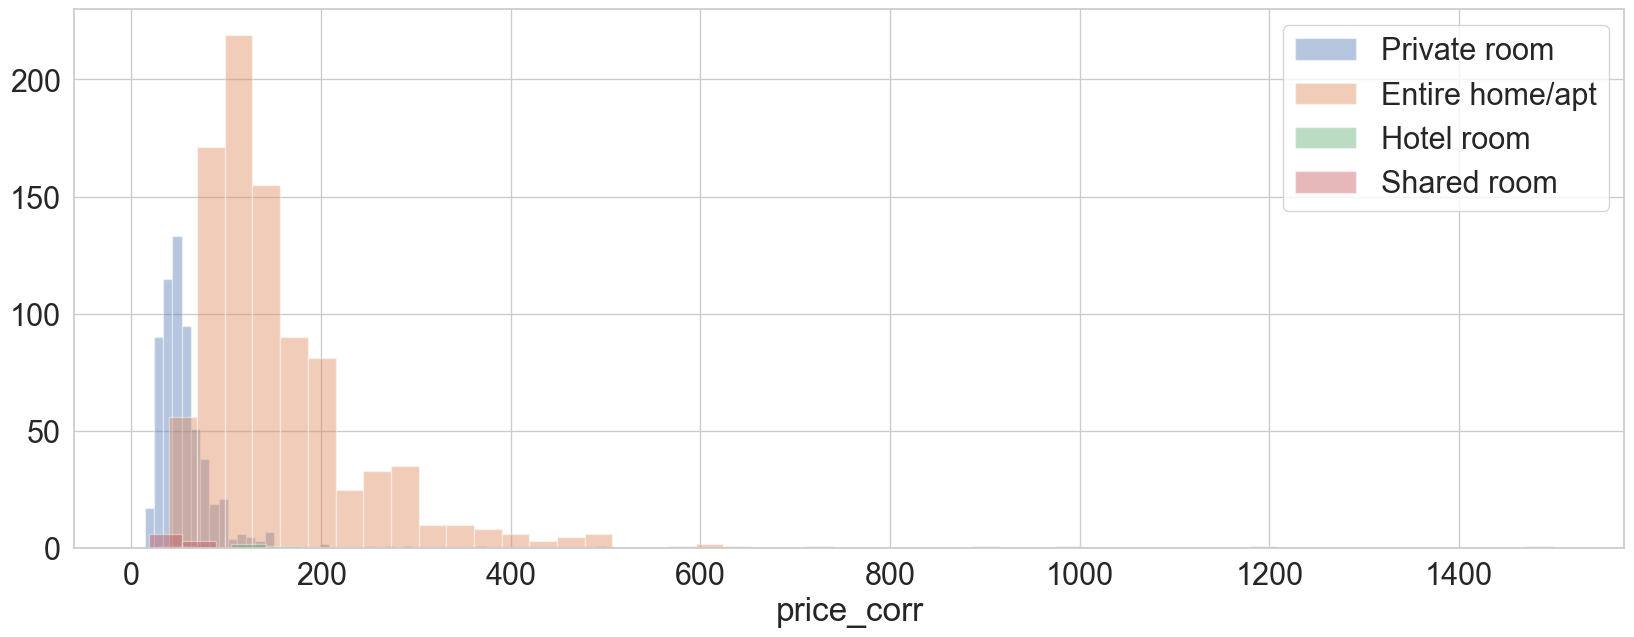

In [18]:
sns.set(
    font_scale =2,
    style      ="whitegrid",
    rc         ={'figure.figsize':(20,7)}
       )
sns.distplot(df[df['room_type'] == "Private room"].price_corr, kde = False, label = 'Private room')
sns.distplot(df[df['room_type'] == "Entire home/apt"].price_corr, kde = False, label = 'Entire home/apt')
sns.distplot(df[df['room_type'] == "Hotel room"].price_corr, kde = False, label = 'Hotel room')
sns.distplot(df[df['room_type'] == "Shared room"].price_corr, kde = False, label = 'Shared room')
plt.legend()

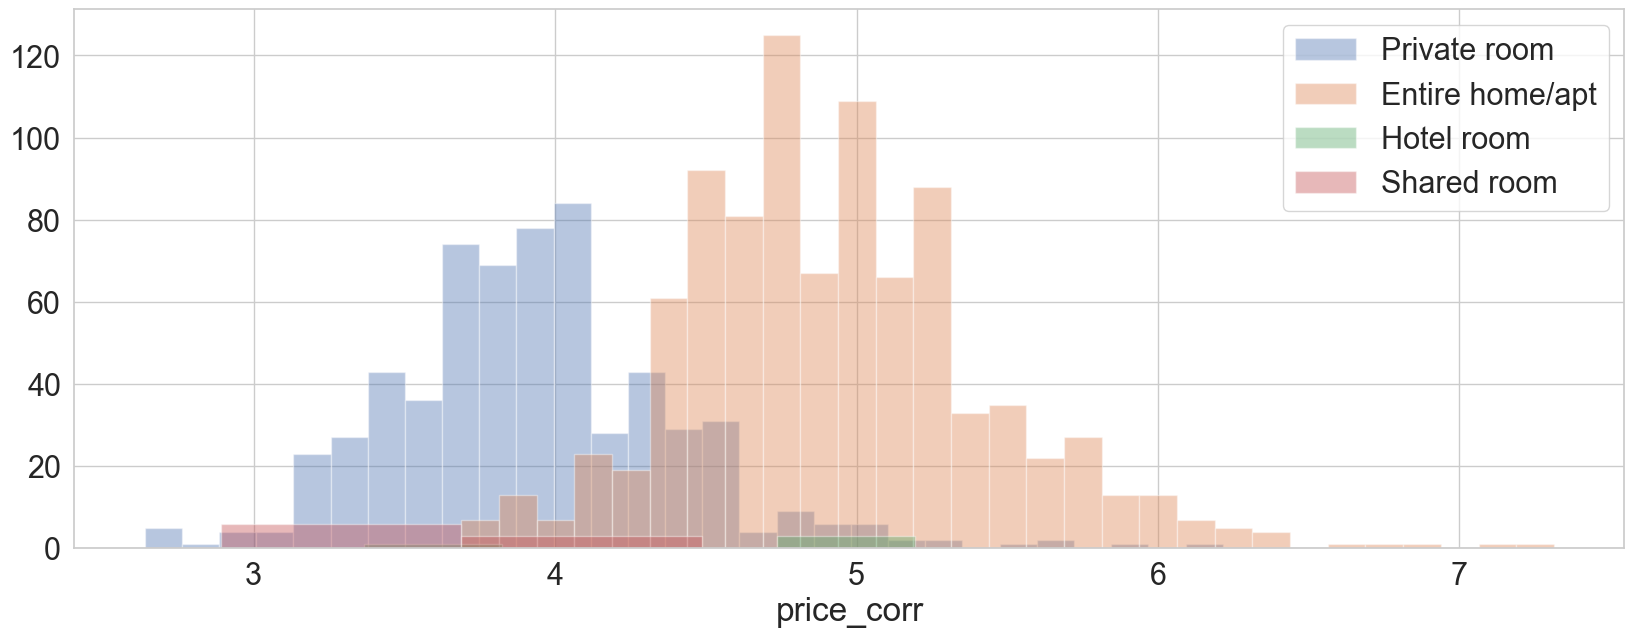

In [19]:
sns.set(
    font_scale =2,
    style      ="whitegrid",
    rc         ={'figure.figsize':(20,7)}
       )
sns.distplot(np.log(df[df['room_type'] == "Private room"].price_corr), kde = False, label = 'Private room')
sns.distplot(np.log(df[df['room_type'] == "Entire home/apt"].price_corr), kde = False, label = 'Entire home/apt')
sns.distplot(np.log(df[df['room_type'] == "Hotel room"].price_corr), kde = False, label = 'Hotel room')
sns.distplot(np.log(df[df['room_type'] == "Shared room"].price_corr), kde = False, label = 'Shared room')
plt.legend()

* **3**
* 4
* 1
* 2
* 5
* **6**

**7. Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Необходимые столбцы:**

* room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
* price – цена за ночь
* first_review – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")

**Ограничение поставьте на 1000 строк.**

**Пример результирующей таблицы:**


| room_type       | price_corr |first_review|
|-----------------|------------|------------|
| Private room    |         65 | 2010-03-23 |
| Entire home/apt |        100 | 2012-01-01 |


**Используя библиотеку seaborn и функцию lineplot, постройте график динамики средних цен на жилье (ось Y) в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X). Датафрейм должен быть отсортирован по годам.**

**Пример датафрейма, который будет служить основой для графика:**


| room_type       | avg_price  | year       |
|-----------------|------------|------------|
| Private room    |         54 | 2010       |
| Entire home/apt |        168 | 2012       |


Hints: line plot; удалите последние 6 символов у значений в столбце даты, чтобы получить год, например, с помощью применения lambda-функции.

**Среди представленных ниже графиков выберите корректный.**

![](https://storage.yandexcloud.net/klms-public/production/learning-content/11/77/598/1724/7855/image.png)

In [20]:
query = """
SELECT 
    room_type, 
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price_corr,
    first_review
FROM ldn_listings
WHERE first_review > '2010-01-01'
LIMIT 1000
"""
df = ph.read_clickhouse(query, connection=connection)
df.head()

,room_type,price_corr,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16


In [21]:
df['year'] = df.first_review.apply(lambda x: x[:4])
df.head()

,room_type,price_corr,first_review,year
0,Private room,65.0,2010-08-18,2010
1,Entire home/apt,300.0,2011-03-21,2011
2,Entire home/apt,65.0,2016-03-05,2016
3,Private room,29.0,2010-04-14,2010
4,Private room,100.0,2010-10-16,2010


In [22]:
df = df.groupby(['year', 'room_type'], as_index = False).agg({'price_corr': 'mean'})
df

,year,room_type,price_corr
0,2010,Entire home/apt,103.500000
1,2010,Hotel room,88.000000
2,2010,Private room,56.428570
3,2011,Entire home/apt,128.792450
4,2011,Private room,52.607143
5,2012,Entire home/apt,135.467255
6,2012,Private room,53.269840
7,2012,Shared room,22.000000
8,2013,Entire home/apt,137.887634
9,2013,Private room,57.036587


<Axes: xlabel='year', ylabel='price_corr'>

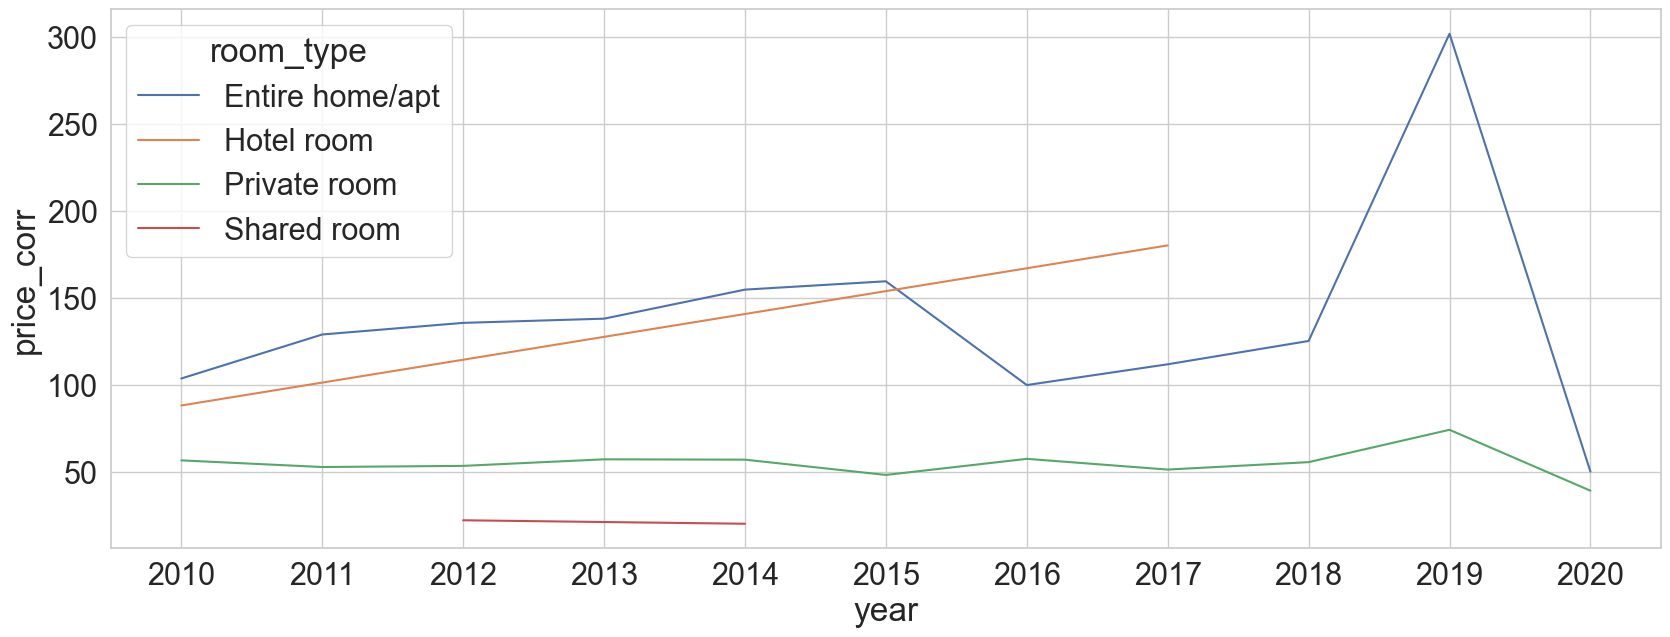

In [23]:
sns.lineplot(data = df, x = 'year', y = 'price_corr', hue = 'room_type')

* **1**
* 2
* 3
* 4